# Curate_PatientsGlobalImpression_of_ChangeScale_Data

In [1]:
import datetime as dt
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import synapseclient
from synapseclient import Activity, File, Schema, Table, as_table_columns
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

tqdm.pandas()

def isnum(x):
    if x is None:
        return False
    try:
        float(x)
        return True
    except ValueError:
        return False

Welcome, Abhishek Pratap!



### Prep V2 data for public release

In [2]:
v2sid = 'syn9974019'

v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['createdAt'])
v2r.columns = ['username', 'mood_1', 'day', 'timestamp']
v2r = v2r.loc[:, ['username', 'timestamp', 'day', 'mood_1']]

v2r.head()

,username,timestamp,day,mood_1
0,EN00409,2016-12-23 00:55:41,7,1
1,EN05109,2016-11-23 15:54:42,12,1
2,EN00619,2016-12-06 21:51:53,4,2
3,EN05107,2016-09-21 21:13:12,3,4
4,EN00610,2016-11-28 16:13:55,3,2


This survey must have been distributed and completed within the first week. Unsure of how the question applies, "Since starting this...how has your mood changed?"

<AxesSubplot:>

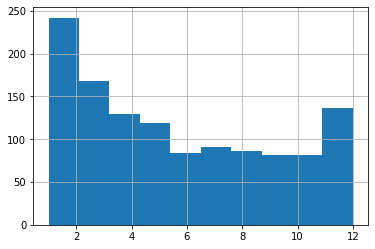

In [3]:
v2r.day.hist()

All mood categories are represented.

<AxesSubplot:>

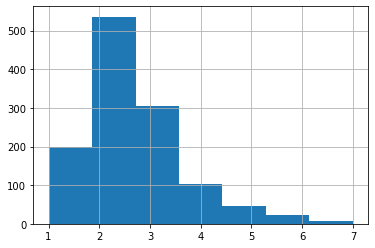

In [4]:
v2r.mood_1.hist(bins=7)

In [ ]:
v2r.reindex(['day', 'mood_1'], axis=1).corr()

### Upload to Synapse

In [ ]:
# name = 'V2_MoodAssessment.csv'
# v2r.to_csv(name, index=None)

# t = syn.setProvenance(
#     syn.store(File(name=name, path=name, parent='')),
#     activity=Activity(
#         name='Public Release',
#         description='Prepare data for public release',
#         used=[v2sid],
#         executed=[
#             dict(
#                 name='IPython Notebook',
#                 url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_Mood_datafiles.ipynb'
#             )
#         ]
#     )
# ); del t

### Prepare Data

In [5]:
v1sid, v2sid = 'syn12181335', 'syn17023109'

v1r = pd.read_csv(syn.get(v1sid).path, parse_dates=['timestamp'])
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['timestamp'])

v1r.head()
v2r.head()

,userid,brightenid,timestamp,timestampUTC,mood_1
0,10431,BLUE-00048,2014-08-08 16:15:08,2014-08-08 15:15:07,No change
1,10519,BLUE-00050,2014-08-23 21:40:29,2014-08-24 04:40:29,Almost the same
2,10519,BLUE-00050,2014-08-30 20:01:01,2014-08-31 00:01:00,Almost the same
3,10617,BLUE-00051,2014-08-11 15:33:48,2014-08-11 19:33:47,Almost the same
4,10617,BLUE-00051,2014-08-18 09:34:21,2014-08-18 13:34:21,Almost the same


,username,timestamp,day,mood_1
0,EN00409,2016-12-23 00:55:41,7,1
1,EN05109,2016-11-23 15:54:42,12,1
2,EN00619,2016-12-06 21:51:53,4,2
3,EN05107,2016-09-21 21:13:12,3,4
4,EN00610,2016-11-28 16:13:55,3,2


### Process V1 Data

In [6]:
v1r.mood_1.value_counts()

A little better        510
Almost the same        491
No change              288
Somewhat better        182
Moderately better      110
Better                  41
A great deal better     14
Name: mood_1, dtype: int64

In [7]:
v1 = v1r.drop(columns=[
    'userid', 'timestampUTC'
]).rename(columns={
    'brightenid':'participant_id',
    'timestamp':'dt_response'
})

# encode the mood response to match v2
def fx(x):
    if x == 'No change':
        return 1
    elif x == 'Almost the same':
        return 2
    elif x == 'A little better':
        return 3
    elif x == 'Somewhat better':
        return 4
    elif x == 'Moderately better':
        return 5
    elif x == 'Better':
        return 6
    elif x == 'A great deal better':
        return 7
    else:
        raise ValueError(f'encoding not mapped: {x}')
    
v1.mood_1 = v1.mood_1.apply(fx)

### Process V2 Data

In [8]:
v2 = v2r.drop(columns=['day']).rename(columns={
    'username':'participant_id',
    'timestamp':'dt_response'
})

### Combine

In [9]:
combined = pd.concat([v1, v2], sort=False)
combined.head()

,participant_id,dt_response,mood_1
0,BLUE-00048,2014-08-08 16:15:08,1
1,BLUE-00050,2014-08-23 21:40:29,2
2,BLUE-00050,2014-08-30 20:01:01,2
3,BLUE-00051,2014-08-11 15:33:48,2
4,BLUE-00051,2014-08-18 09:34:21,2


### Add week into study

In [10]:
metasid = 'syn27082597'
metadata = syn.tableQuery(f'SELECT participant_id, startdate FROM {metasid}').asDataFrame(convert_to_datetime=True)
metadata.startdate = pd.to_datetime(metadata.startdate)

# add in the participants start date as a new column
combined = pd.merge(combined, metadata, on='participant_id', how='left')

# get the time difference in weeks as a float
combined['week'] = [
    d.days/7 for d in (
        combined.dt_response.apply(
            lambda x: dt.datetime(year=x.year, month=x.month, day=x.day))-combined.startdate
    )
]

# convert the week number to an int by taking the floor
combined.week = combined.week.progress_apply(lambda x: np.int16(np.floor(x))+1)# if not pd.isnull(x) else np.nan)

# remove the start date
combined = combined.drop(columns=['startdate'], errors='ignore')

# reorder the columns
cols = list(combined.columns)
cols = cols[0:2] + ['week'] + cols[2:-1]
combined = combined.reindex(columns=cols)

combined.head()

100%|██████████| 2856/2856 [00:00<00:00, 130852.94it/s]


,participant_id,dt_response,week,mood_1
0,BLUE-00048,2014-08-08 16:15:08,4,1
1,BLUE-00050,2014-08-23 21:40:29,3,2
2,BLUE-00050,2014-08-30 20:01:01,4,2
3,BLUE-00051,2014-08-11 15:33:48,2,2
4,BLUE-00051,2014-08-18 09:34:21,3,2


### Localize timestamps

In [11]:
# localize timestamps
combined['dt_response'] = [
    str(t.tz_localize('UTC'))
    for t in combined.dt_response
]

combined.head()

,participant_id,dt_response,week,mood_1
0,BLUE-00048,2014-08-08 16:15:08+00:00,4,1
1,BLUE-00050,2014-08-23 21:40:29+00:00,3,2
2,BLUE-00050,2014-08-30 20:01:01+00:00,4,2
3,BLUE-00051,2014-08-11 15:33:48+00:00,2,2
4,BLUE-00051,2014-08-18 09:34:21+00:00,3,2


### Set provenance and upload to Synapse

In [ ]:
t = syn.delete(
    syn.tableQuery('select * from syn17023313')
)

In [ ]:
final = syn.store(Table(
    Schema(
            name='Mood Assessment',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [14]:
final = syn.setProvenance(
    'syn17023313',
    activity=Activity(
        name='Combine V1 and V2 data',
        description='Process and combine the data collected during study 1 and study 2',
        used=[v1sid, v2sid],
        executed=[
            dict(
                name='Curate_PatientsGlobalImpression_of_ChangeScale_Data',
                url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Curate_PatientsGlobalImpression_of_ChangeScale_Data.ipynb'
            )
        ]
    )
)